<a href="https://colab.research.google.com/github/MnCSSJ4x/VR-MiniProject/blob/main/VR3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Visual Recognition Mini Project 
###Part B: Experimenting With Transfer Learning
#### Authors:
- Rishi Vakharia: IMT2020067
- Karanjit Saha: IMT2020003
- Monjoy Narayan Choudhury: IMT2020502 


In [1]:
import torch 
from torch import optim, cuda
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.datasets import Caltech101
import math 
from torch.utils.data import Dataset, TensorDataset, random_split
from torchvision import transforms

In [2]:
cuda = cuda.is_available()
print(f'Train on gpu: {cuda}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Train on gpu: True


### Dataset Used 
The dataset we are planning to use is the caltech 101 dataset.  It consist of about 40 to 800 images per category. Most categories have about 50 images. Collected in September 2003 by Fei-Fei Li, Marco Andreetto, and Marc'Aurelio Ranzato. The size of each image is roughly 300 x 200 pixels. 

In [3]:
batch_size = 128 

We need to do transformations on the images from this dataset as the model we are intending to use is the AlexNet model trained on ImageNet where the image is of size 224x224. We rescale the image as well as noramise it based on imagenet standards. Other than that since images per class is too low we also try some data augmentation on the train set explictly 

In [4]:
# Image transformations
image_transforms = {
    
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),

    # 'val':
    # transforms.Compose([
    #     transforms.Resize(size=256),
    #     transforms.CenterCrop(size=224),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # ]),


    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [6]:
caltech101 = Caltech101(root='./data',download=True)
len(caltech101)

0it [00:00, ?it/s]

Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


0it [00:00, ?it/s]

Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


8677

In [7]:
r = 0.8 
train_size = math.floor(r*len(caltech101))
test_size = len(caltech101) - train_size 

In [8]:
# Split the dataset into train and test sets
train_set, test_set = torch.utils.data.random_split(caltech101, [train_size,test_size])

train_set = DatasetFromSubset(
    train_set, transform=image_transforms['train']
)
test_set = DatasetFromSubset(
    test_set, transform=image_transforms['test']
)
# Create data loaders for the train and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

In [13]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

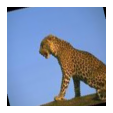

In [33]:
ax = plt.subplot(2,2,1)
_,_ = imshow_tensor(train_set[2][0],ax)

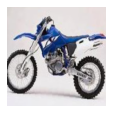

In [34]:
ax = plt.subplot(2,2,1)
_,_ = imshow_tensor(train_set[69][0],ax)

### Pre-trained Model Alexnet 

In [35]:
model = models.alexnet(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
model.classifier[6] = nn.Linear(in_features=4096,out_features=10,bias=True)

In [41]:
model 

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 